# Flyouts
During a play, it is decided whether it will be a groundout, flyout, or hit. This notebook encompasses all baserunner advancement possibilities after a flyout has been decided.

So far, we can confirm that baserunner indulgence is positively correlated with advancing. The formulas are still unclear.

```python
dfc["threshold_1to2"] = -0.085 + 0.36*dfc["runner_on_first_indulgence_with_vibe"] - 0.38*dfc["runner_on_first_indulgence_with_vibe_sq"] \
                               + 0.24*dfc["runner_on_first_indulgence_with_vibe_4"] \
                               - 0.10*(dfc["ballpark_elongation"] - 0.5) - 0.10*(dfc["ballpark_inconvenience"] - 0.5)
dfc["threshold_2to3"] = 0.045 + 0.065*dfc["runner_on_second_indulgence_with_vibe"] + 0.30*dfc["runner_on_second_indulgence_with_vibe_sq"] \
                              - 0.10*(dfc["ballpark_elongation"] - 0.5) - 0.10*(dfc["ballpark_inconvenience"] - 0.5)
dfc["threshold_3to4"] = 0.45 + 0.35*dfc["runner_on_third_indulgence_with_vibe"] - 0.10*(dfc["ballpark_elongation"] - 0.5) - 0.10*(dfc["ballpark_inconvenience"] - 0.5)


```

In [1506]:
# Load Dataframe

import glob

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-flyout.csv")

df = pd.concat((pd.read_csv(f, dtype={'roll': str}) for f in all_files), ignore_index=True)

seasons = [11,12,13,14]
# df = df[df['season'].isin(seasons) & df['stadium_id'].isna()] # Remove stadiums
df = df[df['roll'] != '[]'] # The unpacking code thinks empty is 1 roll, so exclude it here.

# Up to 2 rolls for flyouts, so split them up here
df['roll'] = df['roll'].apply(lambda x: x[1:-1].split(','))
print(df[[len(rolls) == 2 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
print(df[[len(rolls) == 1 for rolls in df['roll'].to_list()]].groupby(['baserunners','baserunners_next']).size())
# print(np.count_nonzero([len(rolls) == 3 for rolls in df['roll'].to_list()]))
splitrolls = pd.DataFrame(df['roll'].to_list(), columns = ['roll1','roll2',], index = df.index)
df[['roll1','roll2']] = splitrolls
df[['roll1','roll2']] = df[['roll1','roll2']].apply(pd.to_numeric)

print(f"{len(df)} events before filtering.")

baserunners  baserunners_next
[2, 0]       [0]                 306
             [1]                  21
[2, 1, 0]    [1, 0]              104
             [2, 0]               39
[2, 1]       [1]                  85
             [2]                  30
[2, 2]       [2]                   1
             []                    1
dtype: int64
baserunners  baserunners_next
[0]          [0]                 3865
             [1]                  211
[1, 0]       [1, 0]               572
             [2, 0]               136
[1]          [1]                 1091
             [2]                  371
[2, 0]       [2, 0]               142
[2, 1, 0]    [2, 1, 0]             67
[2, 1]       [2, 1]                55
[2, 2]       [2, 2]                 2
[2]          [2]                  313
             []                   686
dtype: int64
8098 events before filtering.


In [1507]:
# Vibes

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0
df.loc[df["runner_on_first_mods"].astype(str).str.contains("SCATTERED"), "runner_on_first_vibes"] = 0
df.loc[df["runner_on_second_mods"].astype(str).str.contains("SCATTERED"), "runner_on_second_vibes"] = 0
df.loc[df["runner_on_third_mods"].astype(str).str.contains("SCATTERED"), "runner_on_third_vibes"] = 0

df['batter_inv_patheticism'] = 1-df['batter_patheticism']/df["batter_multiplier"]
df['batter_inv_patheticism_with_vibe'] = df['batter_inv_patheticism'] * (1 + 0.2*df['batter_vibes'])
df['batter_inv_tragicness'] = 1-df['batter_tragicness']/df["batter_multiplier"]
df['batter_inv_tragicness_with_vibe'] = df['batter_inv_tragicness'] * (1 + 0.2*df['batter_vibes'])
df['vibes_mul'] = 1 + 0.2*df['batter_vibes']
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["batter_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["batter_vibes"])
df = df.copy()

for base in ["first","second","third","third_hh"]:
    for attr in [
        f"runner_on_{base}_base_thirst",
        f"runner_on_{base}_continuation",
        f"runner_on_{base}_ground_friction",
        f"runner_on_{base}_indulgence",
        f"runner_on_{base}_laserlikeness",
    ]:
        df[attr + "_scaled"] = df[attr] * df[f"runner_on_{base}_multiplier"]
        df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df[f"runner_on_{base}_vibes"])
df = df.copy()

for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr + "_scaled"] = df[attr] * df["pitcher_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["pitcher_vibes"])
df = df.copy()


for attr in [
    "fielder_anticapitalism",
    "fielder_chasiness",
    "fielder_omniscience",
    "fielder_tenaciousness",
    "fielder_watchfulness",
]:
    df[attr + "_scaled"] = df[attr] * df["fielder_multiplier"]
    df[attr + "_with_vibe"] = df[attr + "_scaled"] * (1 + 0.2 * df["fielder_vibes"])
df = df.copy()

len(df)

8098

In [1508]:
# Ignore multipliers and some mods

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "SHELLED"]:
    df = df[~df["batter_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["fielder_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_second_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["runner_on_third_hh_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["batting_team_mods"].astype(str).str.contains(exclude_mod)]

df = df[
    (df["pitcher_multiplier"] == 1)
    & (df["batter_multiplier"] == 1)
    & (df["fielder_multiplier"] == 1)
    & (df["runner_on_first_multiplier"] == 1)
    & (df["runner_on_second_multiplier"] == 1)
    & (df["runner_on_third_multiplier"] == 1)
    & (df["runner_on_third_hh_multiplier"] == 1)
]

print(len(df))

4851


# Begin Selection

In [1509]:
n_outliers = 0

## Advance First Base to Second Base

### [0] -> [0] (fail) or [1] (pass)
### [2, 0] -> [0] (fail) or [1] (pass)

2430
201
11       0.394549
14       0.626038
15       0.856468
27       0.757485
41       0.749737
           ...   
27873    0.575714
27885    0.073355
27887    0.141122
27888    0.440318
27891    0.622295
Name: roll_advance, Length: 2631, dtype: float64


/tmp/ipykernel_338/2257696171.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["roll_advance"] = X["roll_advance"]+0.1*(X["ballpark_elongation"] - 0.5)
/tmp/ipykernel_338/2257696171.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop("ballpark_elongation", axis="columns", inplace=True)
/tmp/ipykernel_338/2257696171.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,roll_advance,runner_on_first_indulgence_with_vibe,runner_on_first_indulgence_with_vibe_sq,runner_on_first_indulgence_with_vibe_3,runner_on_first_indulgence_with_vibe_4
11,0.394549,1.228512,1.509243,1.854124,2.277814
14,0.626038,0.588240,0.346026,0.203546,0.119734
15,0.856468,0.588240,0.346026,0.203546,0.119734
27,0.757485,0.616486,0.380055,0.234298,0.144442
41,0.749737,0.224903,0.050581,0.011376,0.002558
...,...,...,...,...,...
27873,0.571877,1.019713,1.039814,1.060311,1.081212
27885,0.088049,0.311726,0.097173,0.030291,0.009443
27887,0.137284,0.431490,0.186184,0.080336,0.034664
27888,0.436481,0.431490,0.186184,0.080336,0.034664


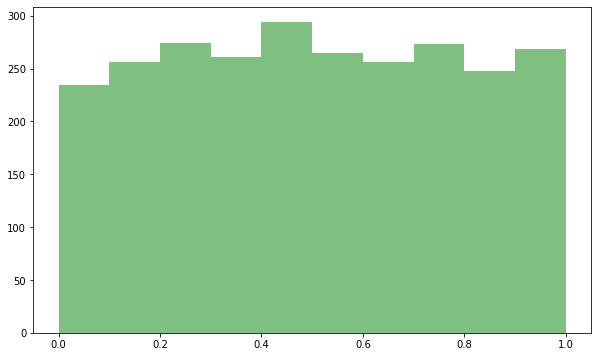

In [1510]:
print(len(df[(df['baserunners'] == "[0]") & (df['baserunners_next'].isin(["[1]","[0]"]))]))
print(len(df[(df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[1]","[0]"]))]))
dfc = df[ \
    ((df['baserunners'] == "[0]") & (df['baserunners_next'].isin(["[1]","[0]"]))) \
    | \
    ((df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[1]","[0]"]))) \
].copy()
dfc["passed"] = ((dfc['baserunners'] == "[0]") & (dfc['baserunners_next'].isin(["[1]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 0]") & (dfc['baserunners_next'].isin(["[1]"]))) \

# Make new roll field since some of these need roll1 and roll2
dfc['roll_advance'] = dfc['roll2']
dfc.loc[df['baserunners'].isin(["[0]"]), 'roll_advance'] = dfc.loc[df['baserunners'].isin(["[0]"]), 'roll1']
print(dfc['roll_advance'])

# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll_advance'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
# dfc = dfc[dfc['runner_on_first_indulgence_with_vibe']>0.5]
# dfc['runner_on_first_indulgence_with_vibe'] -= 0.5
dfc['roll_log'] = dfc['roll_advance'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_log'] = dfc['runner_on_first_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_first_indulgence_with_vibe_sq'] = dfc['runner_on_first_indulgence_with_vibe']**2
dfc['runner_on_first_indulgence_with_vibe_3'] = dfc['runner_on_first_indulgence_with_vibe']**3
dfc['runner_on_first_indulgence_with_vibe_4'] = dfc['runner_on_first_indulgence_with_vibe']**4
dfc['runner_on_first_indulgence_with_vibe_exp'] = dfc['runner_on_first_indulgence_with_vibe'].apply(math.exp)
dfc['threshold_known'] = dfc['runner_on_first_indulgence_with_vibe'] - 0.1*dfc['ballpark_elongation'] - 0.1*dfc['ballpark_inconvenience'] + 0.1
dfc['uhhh'] = dfc["runner_on_first_indulgence_with_vibe"]
dfc['uhhh_2'] = dfc['uhhh']**2
dfc['uhhh_3'] = dfc['uhhh']**3
y = dfc['passed']
X = dfc[
    [
        # "roll_log",
        "roll_advance",
        # "roll_avg",
        # "batter_musclitude_with_vibe",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_first_indulgence_with_vibe_log',
        'runner_on_first_indulgence_with_vibe',
        'runner_on_first_indulgence_with_vibe_sq',
        'runner_on_first_indulgence_with_vibe_3',
        'runner_on_first_indulgence_with_vibe_4',
        # 'runner_on_first_indulgence_with_vibe_exp',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'ballpark_filthiness',
        # 'uhhh',
        # 'uhhh_2',
        # 'uhhh_3',
    ]
]

# Test out a specific coefficient
X["roll_advance"] = X["roll_advance"]+0.1*(X["ballpark_elongation"] - 0.5)
X.drop("ballpark_elongation", axis="columns", inplace=True)
X["roll_advance"] = X["roll_advance"]+0.1*(X["ballpark_inconvenience"] - 0.5)
X.drop("ballpark_inconvenience", axis="columns", inplace=True)
X

In [1511]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
# trainedsvm = svm.SVC(max_iter=100000, C=1000).fit(
#     X2, y
# )
# print(trainedsvm.support_vectors_)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[2516    0]
 [   1  114]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2516
        True       1.00      0.99      1.00       115

    accuracy                           1.00      2631
   macro avg       1.00      1.00      1.00      2631
weighted avg       1.00      1.00      1.00      2631

0.999619916381604


In [1512]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.01011986]


[(1.0, 'roll_advance'),
 (0.4479824673966484, 'runner_on_first_indulgence_with_vibe_3'),
 (-0.333450699893972, 'runner_on_first_indulgence_with_vibe_4'),
 (-0.3242163487903168, 'runner_on_first_indulgence_with_vibe_sq'),
 (0.08456170062121005, 'runner_on_first_indulgence_with_vibe')]

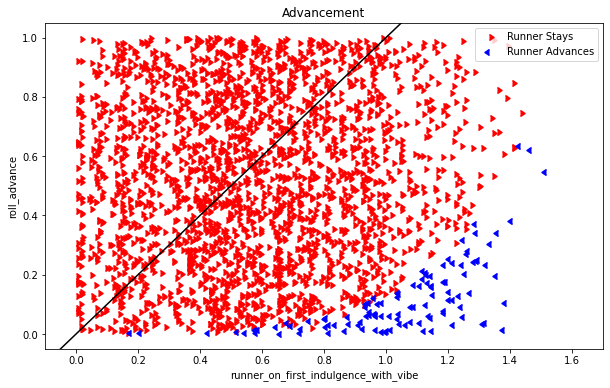

In [1513]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.01 - 0.08*dfc["runner_on_first_indulgence_with_vibe"] + 0.32*dfc["runner_on_first_indulgence_with_vibe_sq"] \
                                - 0.44*dfc["runner_on_first_indulgence_with_vibe_3"] + 0.33*dfc["runner_on_first_indulgence_with_vibe_4"] \
                                - 0.10*(dfc["ballpark_elongation"] - 0.5) - 0.10*(dfc["ballpark_inconvenience"] - 0.5)

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll_advance":
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

# x_val = "threshold"
x_val = "runner_on_first_indulgence_with_vibe"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll_advance"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll_advance"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll_advance")
ax.set_title("Advancement")
ax.set_xlim(-0.1, 1.7)
ax.set_ylim(-0.05, 1.05)
ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


6 outliers


,passed,offset,roll_advance,threshold_rounded,event_type,inning,runner_on_first_name,fielder_name,runner_on_first_mods,fielder_mods,batting_team_mods,pitching_team_mods,weather,season,day,game_id,play_count
1705,False,-0.002304,0.106581,0.108885,flyout,2,Alexander Horne,Greer Gwiffin,NaN,NaN,LOVE,NaN,Weather.COFFEE,11,53,ce5cad0e-2935-43b9-8f1e-8d54b858a6f3,82
7971,False,-0.001154,0.133615,0.134768,flyout,1,Andrew Solis,Fish Summer,FIRE_EATER,FIRE_EATER,BIRD_SEED,EARLBIRDS,Weather.PEANUTS,12,37,fbb58814-ecba-4337-add2-d77b26c7c11d,38
9051,False,-0.003321,0.098669,0.101989,flyout,5,Cannonball Sports,Malik Romayne,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,NaN,Weather.REVERB,12,49,90153b07-901a-490c-820e-037b1ba9d1ab,221
14770,False,-0.001544,0.353989,0.355533,flyout,2,Don Mitchell,Zephyr McCloud,REVERBERATING,NaN,LOVE,NaN,Weather.FLOODING,13,22,9d4e43b4-92c9-455c-80e1-59790685a2f1,77
22932,False,-0.000911,0.067941,0.068851,flyout,7,Cannonball Sports,Fran Beans,NaN,SWIM_BLADDER,LIFE_OF_PARTY;ELECTRIC,NaN,Weather.SALMON,14,37,eaf77b2b-4f3d-4f5e-a721-09ba60c43686,256
25541,False,-0.005561,0.307499,0.313060,flyout,2,Dickerson Morse,J-xon B-ck-ey,NaN,FIRE_EATER;SCATTERED,NaN,AFFINITY_FOR_CROWS,Weather.COFFEE_3S,14,68,32ddf5bb-98e4-48c8-b44d-37cdfafaf769,74


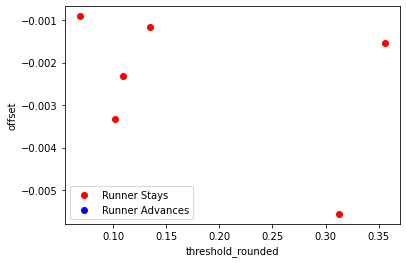

In [1514]:
# Plot outliers
dfc["offset"] = dfc["roll_advance"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "offset",
        "roll_advance",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "fielder_name",
        "runner_on_first_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
]

## Advance Second Base to Third Base

### [1] -> [1] (fail) or [2] (pass)
### [1, 0] -> [1, 0] (fail) or [2, 0] (pass)
### [2, 1] -> [1] (fail) or [2] (pass)
### [2, 1, 0] -> [1, 0] (fail) or [2, 0] (pass)

897
425
75
90
5        0.476022
8        0.664488
10       0.131786
38       0.188731
54       0.767382
           ...   
27748    0.035956
27753    0.767516
27754    0.529393
27804    0.691690
27894    0.905880
Name: roll_advance, Length: 1487, dtype: float64


/tmp/ipykernel_338/3153217019.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["roll_advance"] = X["roll_advance"]+0.1*X["ballpark_elongation"]
/tmp/ipykernel_338/3153217019.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop("ballpark_elongation", axis="columns", inplace=True)
/tmp/ipykernel_338/3153217019.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,roll_advance,runner_on_second_indulgence_with_vibe,runner_on_second_indulgence_with_vibe_sq
5,0.576022,0.409026,0.167302
8,0.764488,0.247573,0.061292
10,0.231786,0.247573,0.061292
38,0.288731,0.536595,0.287934
54,0.867382,0.866326,0.750520
...,...,...,...
27748,0.145170,0.383539,0.147102
27753,0.871706,0.963317,0.927981
27754,0.638000,0.768357,0.590372
27804,0.800296,1.118343,1.250691


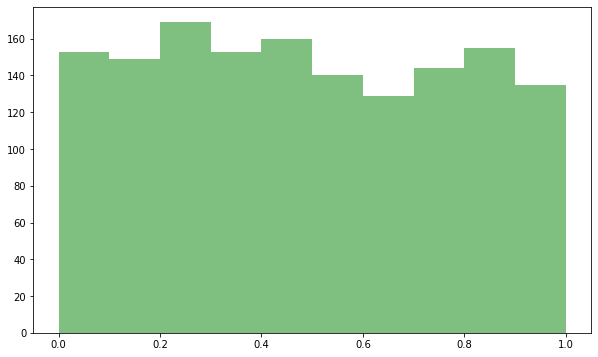

In [1515]:
print(len(df[(df['baserunners'] == "[1]") & (df['baserunners_next'].isin(["[2]","[1]"]))]))
print(len(df[(df['baserunners'] == "[1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))]))
print(len(df[(df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2]","[1]"]))]))
print(len(df[(df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))]))
dfc = df[ \
    ((df['baserunners'] == "[1]") & (df['baserunners_next'].isin(["[2]","[1]"]))) \
    | \
    ((df['baserunners'] == "[1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))) \
    | \
    ((df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2]","[1]"]))) \
    | \
    ((df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 0]","[1, 0]"]))) \
].copy()
dfc["passed"] = ((dfc['baserunners'] == "[1]") & (dfc['baserunners_next'].isin(["[2]"]))) \
                | \
                ((dfc['baserunners'] == "[1, 0]") & (dfc['baserunners_next'].isin(["[2, 0]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1]") & (dfc['baserunners_next'].isin(["[2]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1, 0]") & (dfc['baserunners_next'].isin(["[2, 0]"])))

# Make new roll field since some of these need roll1 and roll2
dfc['roll_advance'] = dfc['roll2']
dfc.loc[df['baserunners'].isin(["[1]","[1, 0]"]), 'roll_advance'] = dfc.loc[df['baserunners'].isin(["[1]","[1, 0]"]), 'roll1']
print(dfc['roll_advance'])

# dfc = df[df['baserunners'] == "[1]"]
# Define the final state runners as well
# dfc = dfc[dfc['baserunners_next'].isin(["[1]","[2]"])]
# print(len(dfc[~dfc['roll2'].isna()]))
# dfc["passed"] = dfc['baserunners_next'].str.contains("[2]")
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll_advance'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
# dfc['roll1'] = dfc['roll1'].apply(lambda x: x)
dfc['roll_log'] = dfc['roll_advance'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_log'] = dfc['runner_on_second_indulgence_with_vibe'].apply(math.log)
dfc['runner_on_second_indulgence_with_vibe_sq'] = dfc['runner_on_second_indulgence_with_vibe']**2
dfc['runner_on_second_indulgence_with_vibe_pow'] = dfc['runner_on_second_indulgence_with_vibe']**3.5
y = dfc["passed"]
X = dfc[
    [
        # "roll_log",
        "roll_advance",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        # 'runner_on_second_indulgence_with_vibe_log',
        'runner_on_second_indulgence_with_vibe',
        'runner_on_second_indulgence_with_vibe_sq',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
X["roll_advance"] = X["roll_advance"]+0.1*X["ballpark_elongation"]
X.drop("ballpark_elongation", axis="columns", inplace=True)
X["roll_advance"] = X["roll_advance"]+0.1*X["ballpark_inconvenience"]
X.drop("ballpark_inconvenience", axis="columns", inplace=True)
X

In [1516]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[1128    2]
 [   2  355]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1130
        True       0.99      0.99      0.99       357

    accuracy                           1.00      1487
   macro avg       1.00      1.00      1.00      1487
weighted avg       1.00      1.00      1.00      1487

0.9973100201748487


In [1517]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.14695043]


[(1.0, 'roll_advance'),
 (-0.30720110351325436, 'runner_on_second_indulgence_with_vibe_sq'),
 (-0.05573259282274496, 'runner_on_second_indulgence_with_vibe')]

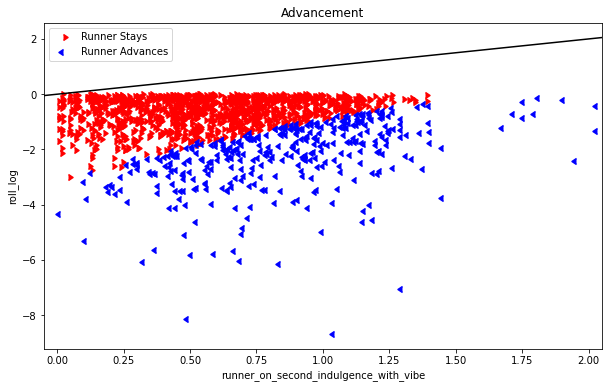

In [1518]:
# Plot vs a single mod
# x_val = "threshold_known"
x_val = "runner_on_second_indulgence_with_vibe"
y_val = "roll_log"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.set_title("Advancement")
ax.set_xlim(-0.05, 2.05)
# ax.set_ylim(-0.05, 1.05)
ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()

# print(dfc[(dfc['runner_on_first_indulgence_with_vibe']<0.50) & dfc['passed']])
# print(dfc[(dfc['roll_advance']<0.01)][['passed','roll_advance',"runner_on_first_indulgence_with_vibe"]])
# print(dfc[(dfc['roll_advance']<0.05)&(dfc['runner_on_first_indulgence_with_vibe']<0.5)][['passed','roll_advance',"runner_on_first_indulgence_with_vibe"]])

[0.14695043]
(0.05573259282274496, 'runner_on_second_indulgence_with_vibe')
(0.30720110351325436, 'runner_on_second_indulgence_with_vibe_sq')


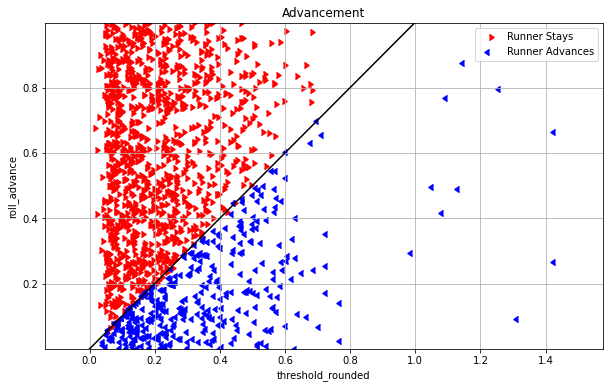

In [1519]:
# Make scatter plot

# Manual threshold
# dfc["threshold_rounded"] = 1.5*dfc["runner_on_second_indulgence_with_vibe_log"]
# dfc["threshold_rounded"] = dfc["runner_on_second_indulgence_with_vibe"]/math.exp(1)
# dfc["threshold_rounded"] = ((dfc["runner_on_second_indulgence_with_vibe"] + 0.2)**2)/3.5
dfc["threshold_rounded"] = 0.045 + 0.065*dfc["runner_on_second_indulgence_with_vibe"] + 0.30*dfc["runner_on_second_indulgence_with_vibe_sq"] \
                                 - 0.10*(dfc["ballpark_elongation"] - 0.5) - 0.10*(dfc["ballpark_inconvenience"] - 0.5)
# print(dfc[dfc["threshold_rounded"]>1]["runner_on_second_name"])
# dfc["threshold_rounded"] = 0.50 + 0.35 * dfc["runner_on_second_indulgence_with_vibe"] - 0.10 * (dfc['ballpark_elongation'] - 0.50)
# print(dfc[dfc['passed'] & (dfc['runner_on_second_indulgence_with_vibe']<0.2)][['roll_advance','runner_on_second_mods','runner_on_second_indulgence_with_vibe','season','day']])

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll_advance":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

# x_val = "runner_on_second_indulgence_with_vibe"
x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll_advance"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll_advance"],
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll_advance")
ax.set_title("Advancement")
ax.grid()
# ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")
# ax.set_xlim(dfc["threshold_rounded"].min(),dfc["threshold_rounded"].max())
ax.set_ylim(dfc["roll_advance"].min(),dfc["roll_advance"].max())

ax.legend()


3 outliers


,passed,offset,roll_advance,threshold_rounded,event_type,inning,runner_on_second_name,fielder_name,runner_on_second_mods,fielder_mods,batting_team_mods,pitching_team_mods,weather,season,day,game_id,play_count
23021,False,-0.003819,0.247135,0.250954,flyout,6,Lotus Mango,Kichiro Guerra,COFFEE_PERIL,ALTERNATE;MAXIMALIST,NaN,LOVE,Weather.SALMON,14,38,927dc1be-53c8-4a9f-a308-1b04692ecaf7,272
23367,False,-0.001970,0.200470,0.202440,flyout,6,Yrjö Kerfuffle,Engine Eberhardt,NaN,NaN,NaN,POPCORN_PAYOUTS,Weather.FLOODING,14,42,9d5acaf7-0b16-4c70-b1d2-622b6ecbeabb,226
15669,True,0.001557,0.447863,0.446306,flyout,5,Stephens Lightner,Cannonball Sports,NaN,NaN,EARLBIRDS,LIFE_OF_PARTY;ELECTRIC,Weather.BLACK_HOLE,13,37,b912a4a9-fe0f-4f6a-8230-286b4ef1b66f,179


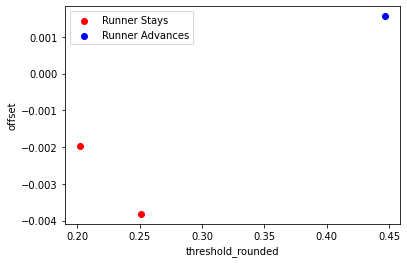

In [1520]:
# Outliers
dfc["offset"] = dfc["roll_advance"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "offset",
        "roll_advance",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_second_name",
        "fielder_name",
        "runner_on_second_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Advance Third Base to Home (no hand-holding)

### [2] -> [2] (fail) or [] (pass)
### [2, 0] -> [2, 0] (fail) or [0] or [1] (pass)
### [2, 1] -> [2, 1] (fail) or [1] or [2] (pass)
### [2, 1, 0] -> [2, 1, 0] (fail) or [1, 0] or [2, 0] (pass)

575
131
113
278


,roll1,runner_on_third_indulgence_with_vibe,ballpark_inconvenience,ballpark_elongation
5,0.232033,0.945747,0.500000,0.500000
12,0.596690,0.546263,0.500000,0.500000
52,0.222176,0.161536,0.500000,0.500000
75,0.894571,0.704957,0.500000,0.500000
94,0.042973,0.404583,0.500000,0.500000
...,...,...,...,...
27695,0.961126,0.358063,0.681991,0.404077
27698,0.186565,1.135886,0.495179,0.596597
27708,0.035988,0.458818,0.544278,0.547866
27753,0.095954,0.884379,0.451727,0.590171


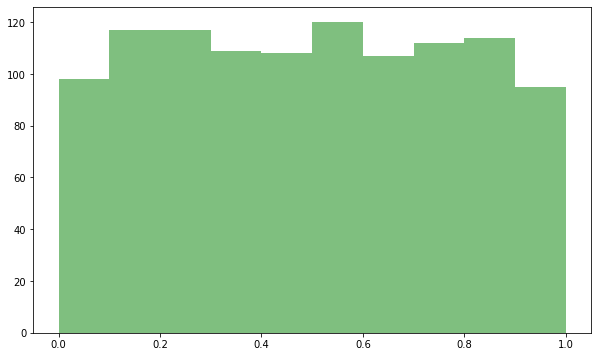

In [1521]:
# Bring in all situations with a runner on 3rd since the first roll is always to check if 3rd base advances
# print(df['baserunners'] == "[2]")
# print(df['baserunners_next'].isin(["[2]","[]"]))
# test = df['baserunners_next'].isin(["[]"])
print(len(df[(df['baserunners'] == "[2]") & (df['baserunners_next'].isin(["[2]","[]"]))]))
print(len(df[(df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 1, 0]","[1, 0]","[2, 0]"]))]))
print(len(df[(df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2, 1]","[1]","[2]"]))]))
print(len(df[(df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[2, 0]","[0]","[1]"]))]))
dfc = df[ \
    ((df['baserunners'] == "[2]") & (df['baserunners_next'].isin(["[2]","[]"]))) \
    | \
    ((df['baserunners'] == "[2, 1, 0]") & (df['baserunners_next'].isin(["[2, 1, 0]","[1, 0]","[2, 0]"]))) \
    | \
    ((df['baserunners'] == "[2, 1]") & (df['baserunners_next'].isin(["[2, 1]","[1]","[2]"]))) \
    | \
    ((df['baserunners'] == "[2, 0]") & (df['baserunners_next'].isin(["[2, 0]","[0]","[1]"]))) \
].copy()
dfc["passed"] = ((dfc['baserunners'] == "[2]") & (dfc['baserunners_next'].isin(["[]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1, 0]") & (dfc['baserunners_next'].isin(["[1, 0]","[2, 0]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 1]") & (dfc['baserunners_next'].isin(["[1]","[2]"]))) \
                | \
                ((dfc['baserunners'] == "[2, 0]") & (dfc['baserunners_next'].isin(["[1]","[0]"])))

# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# dfc["passed"] = ~dfc['baserunners_next'].str.contains("[2]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
dfc['runner_on_third_indulgence_with_vibe_sq'] = dfc['runner_on_third_indulgence_with_vibe']**2
y = dfc["passed"]
X = dfc[
    [
        "roll1",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        'runner_on_third_indulgence_with_vibe',
        # 'runner_on_third_indulgence_with_vibe_sq',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]+0.1*X["ballpark_elongation"]
# X.drop("ballpark_elongation", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]+0.1*X["ballpark_inconvenience"]
# X.drop("ballpark_inconvenience", axis="columns", inplace=True)
X

In [1522]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[336   0]
 [  0 761]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       336
        True       1.00      1.00      1.00       761

    accuracy                           1.00      1097
   macro avg       1.00      1.00      1.00      1097
weighted avg       1.00      1.00      1.00      1097

1.0


In [1523]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.55894893]


[(1.0, 'roll1'),
 (-0.3468665597619854, 'runner_on_third_indulgence_with_vibe'),
 (0.11139327551307564, 'ballpark_elongation'),
 (0.10294458394001826, 'ballpark_inconvenience')]

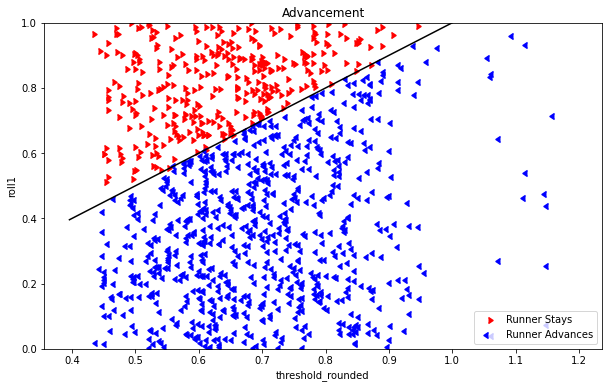

In [1524]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.45 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * (dfc["ballpark_elongation"] - 0.5) - 0.10 * (dfc["ballpark_inconvenience"] - 0.5)
for thing in range(0,300,10):
    dfc.loc[dfc["threshold_rounded"].idxmax()]['threshold_rounded']

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll1":
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


0 outliers


,offset,passed,roll1,threshold_rounded,event_type,inning,runner_on_first_name,runner_on_first_mods,batting_team_mods,fielder_name,fielder_mods,pitcher_name,pitcher_mods,pitching_team_mods,season,day,game_id,play_count


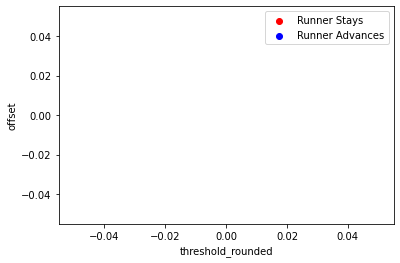

In [1525]:
# Outliers
dfc["offset"] = dfc["roll1"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll1",
        "threshold_rounded",
        "event_type",
        "inning",
        "runner_on_first_name",
        "runner_on_first_mods",
        "batting_team_mods",
        "fielder_name",
        "fielder_mods",
        "pitcher_name",
        "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Runners Holding Hands on Third (roll1)

### [2, 2] -> [2, 2] (fail) or [2] (pass) or [] (pass)


2
     baserunners baserunners_next
5644      [2, 2]              [2]
8292      [2, 2]           [2, 2]


(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

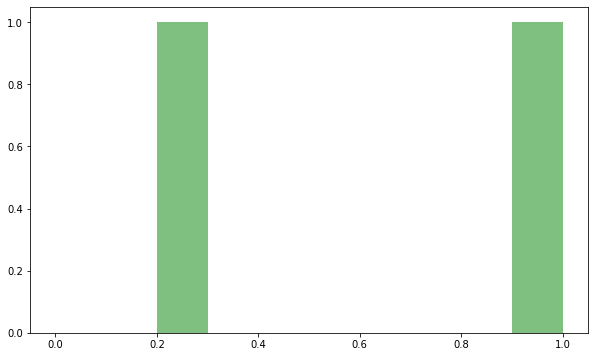

In [1526]:
print(len(df[(df['baserunners'] == "[2, 2]") & (df['baserunners_next'].isin(["[2, 2]","[2]","[]"]))]))
dfc = df[(df['baserunners'] == "[2, 2]") & (df['baserunners_next'].isin(["[2, 2]","[2]","[]"]))].copy()
dfc["passed"] = (dfc['baserunners_next'].isin(["[2]","[]"]))
print(dfc[['baserunners','baserunners_next']])

# This time look at roll1
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll1'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

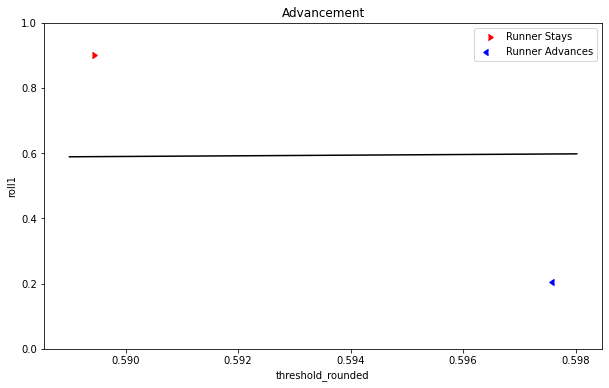

In [1527]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.45 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * (dfc["ballpark_elongation"] - 0.5) - 0.10 * (dfc["ballpark_inconvenience"] - 0.5)
for thing in range(0,300,10):
    dfc.loc[dfc["threshold_rounded"].idxmax()]['threshold_rounded']

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll1"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll1"],
    
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll1")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


## Runners Holding Hands on Third (roll2)

### [2, 2] -> [2] (fail) or [] (pass)


1
     baserunners baserunners_next
5644      [2, 2]              [2]


(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

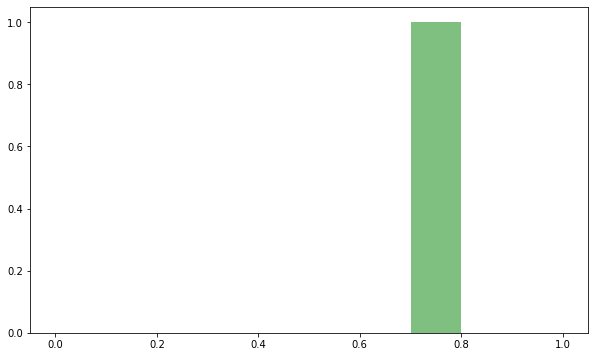

In [1528]:
print(len(df[(df['baserunners'] == "[2, 2]") & (df['baserunners_next'].isin(["[2]","[]"]))]))
dfc = df[(df['baserunners'] == "[2, 2]") & (df['baserunners_next'].isin(["[2]","[]"]))].copy()
dfc["passed"] = (dfc['baserunners_next'].isin(["[]"]))
print(dfc[['baserunners','baserunners_next']])

# This time look at roll2
# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll2'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)

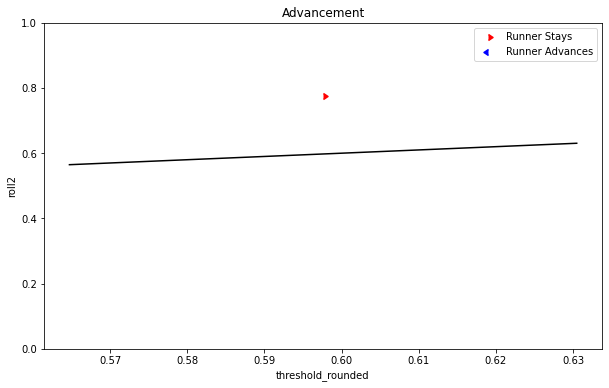

In [1529]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.45 + 0.35 * dfc["runner_on_third_indulgence_with_vibe"] - 0.10 * (dfc["ballpark_elongation"] - 0.5) - 0.10 * (dfc["ballpark_inconvenience"] - 0.5)
for thing in range(0,300,10):
    dfc.loc[dfc["threshold_rounded"].idxmax()]['threshold_rounded']

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll2"],
    color="red",
    label="Runner Stays",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll2"],
    
    color="blue",
    label="Runner Advances",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll2")
ax.set_title("Advancement")
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()
